In [1]:
from holodecml.data import load_raw_datasets, scale_images
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import xarray as xr
import os
from os.path import join
from scipy.ndimage import label, center_of_mass


In [2]:
path_data = "/glade/p/cisl/aiml/ai4ess_hackathon/holodec/"
num_particles = "medium"
output_cols = ["x", "y", "z", "d", "hid"]
subset = 0.01
scaler_out = MinMaxScaler()
path_preds = "/glade/p/cisl/aiml/ggantos/holodec/unet/j_10_fulldata/valid_outputs_pred.nc"
rad = 32


In [3]:
train_inputs_raw, train_outputs_raw = load_raw_datasets(path_data, num_particles,
                                                        'train', output_cols, subset)


In [4]:
valid_inputs_raw, valid_outputs_raw = load_raw_datasets(path_data, num_particles,
                                                'valid', output_cols, False)

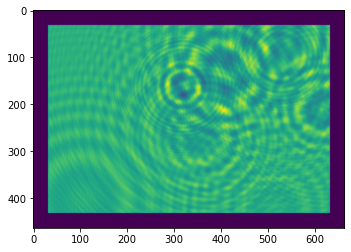

In [5]:
plt.imshow(np.pad(train_inputs_raw[0], 32).T)

In [6]:
train_outputs_raw["x_bin"] = np.digitize(train_outputs_raw['x'], np.linspace(-888, 888, 600))
train_outputs_raw["y_bin"] = np.digitize(train_outputs_raw['y'], np.linspace(-592, 592, 400))

patches = []
for hid in train_outputs_raw["hid"].unique():
    input_hid = np.pad(train_inputs_raw[int(hid)-1], 32)
    outputs_hid = train_outputs_raw.loc[train_outputs_raw['hid'] == hid]
    for index, row in outputs_hid.iterrows():
        idx_x, idx_y = int(row["x_bin"])+32, int(row["y_bin"])+32
        patch = input_hid[idx_x-32:idx_x+32+1, idx_y-32:idx_y+32+1]
        patches.append(patch)
patches = np.stack(patches)


In [7]:
preds = xr.open_dataset("/glade/p/cisl/aiml/ggantos/holodec/unet/j_10_fulldata/valid_outputs_pred.nc").to_array()[0, :, :, :, 0]


In [8]:
len(preds)

10000

In [9]:
coms = []
for pred in preds:
    holo_label, label_count = label(np.where(pred >= 0.3, 1, 0))
    com = np.array(center_of_mass(pred, holo_label, np.arange(1, label_count+1)))
    com = np.round(com).astype(int)
    coms.append(com)
#     plt.pcolormesh(np.ma.array(holo_label, mask=holo_label<1))
#     plt.scatter(com[:,1], com[:, 0])
#     plt.show()


In [10]:
len(coms)

10000

In [11]:
for c in coms[0]:
    print(c)

[ 3 33]
[ 8 11]
[11 13]
[13 15]
[15 17]
[16 13]
[20 27]
[21 36]
[33 11]
[41 22]
[43  2]
[44 37]
[49 16]
[55 19]


In [13]:
def load_train_patches(path_data, path_preds, num_particles, output_cols,
                       scaler_out=False, subset=False, rad=False, threshold=0.3):
    
    '''Creates hologram patches centered around true (for train) and predicted (for validation) particles.'''
    
    # load raw datasets
    train_inputs,\
    train_outputs = load_raw_datasets(path_data, num_particles, 'train',
                                      output_cols, subset)
    valid_inputs,\
    valid_outputs = load_raw_datasets(path_data, num_particles, 'valid',
                                      output_cols, subset)
    
    # scale images
    train_inputs, scaler_in = scale_images(train_inputs)
    valid_inputs, _ = scale_images(valid_inputs, scaler_in)
    
    # bin x and y
    train_outputs["x_bin"] = np.digitize(train_outputs['x'], np.linspace(-888, 888, 600))
    train_outputs["y_bin"] = np.digitize(train_outputs['y'], np.linspace(-592, 592, 400))
    
    # excise patches from zero-padded holograms for training set
    train_patches = []
    for hid in train_outputs["hid"].unique().astype(int):
        input_hid = np.pad(train_inputs[hid-1], rad)
        outputs_hid = train_outputs.loc[train_outputs['hid'] == hid]
        for _,row in outputs_hid.iterrows():
            idx_x, idx_y = int(row["x_bin"])+rad, int(row["y_bin"])+rad
            patch = input_hid[idx_x-rad:idx_x+rad+1, idx_y-rad:idx_y+rad+1]
            train_patches.append(patch)
    train_patches = np.stack(train_patches)

    # use scipy.ndimage.label and scipy.ndimage.center_of_mass to extract predicted particles
    preds = xr.open_dataset(path_preds).to_array()[0, :, :, :, 0]
    coms = []
    for pred in preds:
        holo_label, label_count = label(np.where(pred >= threshold, 1, 0))
        com = np.array(center_of_mass(pred, holo_label, np.arange(1, label_count+1)))
        coms.append(np.round(com).astype(int))

    # calculate bin factor from inputs to the jnet model
    x_factor = valid_inputs.shape[1] // preds.x.shape[0]
    y_factor = valid_inputs.shape[2] // preds.y.shape[0]
    
    # exise patches from zero-padded holograms for validation set
    valid_patches = []
    for hid in valid_outputs["hid"].unique().astype(int):
        input_hid = np.pad(valid_inputs[hid-1], rad)
        com = coms[hid-1]
        for c in com:
#             print(c)
#             print("*factor", int(c[0]*x_factor), int(c[1]*y_factor))
#             print(int(c[0]*x_factor)+rad, int(c[1]*y_factor)+rad)
#             print(idx_x-rad, " to ", idx_x+rad+1, idx_y-rad, " to ", idx_y+rad+1)
            idx_x, idx_y = int(c[0]*x_factor)+rad, int(c[1]*y_factor)+rad            
            patch = input_hid[idx_x-rad:idx_x+rad+1, idx_y-rad:idx_y+rad+1]
#             print(patch.shape)
            valid_patches.append(patch)
    valid_patches = np.stack(valid_patches)
    
    train_outputs = train_outputs.drop(['hid', 'x_bin', 'y_bin'], axis=1)
    train_outputs = scaler_out.fit_transform(train_outputs)
    
    valid_outputs = valid_outputs.drop(['hid'], axis=1)
    valid_outputs = scaler_out.transform(valid_outputs)
    
    return train_patches, train_outputs, valid_patches, valid_outputs


In [ ]:
subset = False

train_patches,\
train_outputs,\
valid_patches,\
valid_outputs = load_train_patches(path_data, path_preds, num_particles, output_cols,
                       scaler_out=scaler_out, subset=subset, rad=rad)


In [3]:
def get_linspace(input_shape):
    if input_shape == (600, 400):
        return np.linspace(-888, 888, 600), np.linspace(-592, 592, 400)
    if input_shape == (512, 512):
        return np.linspace(-757, 757, 512), np.linspace(-757, 757, 512)
    if input_shape == (1200, 800):
        return np.linspace(-1776, 1776, 1200), np.linspace(-1776, 1776, 800)   


In [4]:
def load_train_patches(path_data, num_particles, output_cols,
                       scaler_out=False, subset=False, rad=False, threshold=0.3):
    
    '''Creates hologram patches centered around true particles.'''
    
    # load raw datasets
    train_inputs,\
    train_outputs = load_raw_datasets(path_data, num_particles, 'train',
                                      output_cols, subset)
    valid_inputs,\
    valid_outputs = load_raw_datasets(path_data, num_particles, 'valid',
                                      output_cols, subset)
    
    # scale images
    train_inputs, scaler_in = scale_images(train_inputs)
    valid_inputs, _ = scale_images(valid_inputs, scaler_in)
    
    # bin x and y coordinates
    x_linspace, y_linspace = get_linspace(train_inputs[0].shape)
    train_outputs["x_bin"] = np.digitize(train_outputs['x'], x_linspace)
    train_outputs["y_bin"] = np.digitize(train_outputs['y'], y_linspace)
    valid_outputs["x_bin"] = np.digitize(valid_outputs['x'], x_linspace)
    valid_outputs["y_bin"] = np.digitize(valid_outputs['y'], y_linspace)
    
    # excise patches from zero-padded holograms for training set
    train_patches = []
    for hid in train_outputs["hid"].unique().astype(int):
        input_hid = np.pad(train_inputs[hid-1], rad)
        outputs_hid = train_outputs.loc[train_outputs['hid'] == hid]
        for _,row in outputs_hid.iterrows():
            idx_x, idx_y = int(row["x_bin"])+rad, int(row["y_bin"])+rad
            patch = input_hid[idx_x-rad:idx_x+rad+1, idx_y-rad:idx_y+rad+1]
            train_patches.append(patch)
    train_patches = np.stack(train_patches)

    # excise patches from zero-padded holograms for validation set
    valid_patches = []
    for hid in valid_outputs["hid"].unique().astype(int):
        input_hid = np.pad(valid_inputs[hid-1], rad)
        outputs_hid = valid_outputs.loc[valid_outputs['hid'] == hid]
        for _,row in outputs_hid.iterrows():
            idx_x, idx_y = int(row["x_bin"])+rad, int(row["y_bin"])+rad
            patch = input_hid[idx_x-rad:idx_x+rad+1, idx_y-rad:idx_y+rad+1]
            valid_patches.append(patch)
    valid_patches = np.stack(valid_patches)
    
    
    train_outputs = train_outputs.drop(['hid', 'x_bin', 'y_bin'], axis=1)
    train_outputs = scaler_out.fit_transform(train_outputs)
    
    valid_outputs = valid_outputs.drop(['hid', 'x_bin', 'y_bin'], axis=1)
    valid_outputs = scaler_out.transform(valid_outputs)
    
    return train_patches, train_outputs, valid_patches, valid_outputs


In [5]:
subset = 0.10

train_patches,\
train_outputs,\
valid_patches,\
valid_outputs = load_train_patches(path_data, num_particles, output_cols,
                       scaler_out=scaler_out, subset=subset, rad=rad)


In [6]:
train_patches.shape

(147673, 65, 65)

In [7]:
valid_patches.shape

(18378, 65, 65)

In [ ]:
f